In [63]:
# -*- coding: utf-8 -*-
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # pandas is a library for handling datasets
import os # to move around your operating system
import scipy as sp  # scientific computation library
import pylab

from mpl_toolkits.mplot3d import axes3d # in case we need to plot in 3D z=f(x,y)
import seaborn as sns  # another package for pretty graphs

# Scikit-learn (sklearn) is a powerful and fairly comprehensive library of ML algorithms
from sklearn import datasets
from sklearn.neighbors.kde import KernelDensity

In [64]:
#splitting data into input and target
data = datasets.load_iris(return_X_y=True)
input_data = data[0]
target_data = np.reshape(data[1], (len(data[0]), 1))
#print(input_data)

In [65]:
# splitting input data into classes
class_0 = []
class_1 = []
class_2 = []
for i in range(len(target_data)):
    if(target_data[i] == 0):
        class_0.append(input_data[i])
    elif(target_data[i] == 1):
        class_1.append(input_data[i])
    else:
        class_2.append(input_data[i])
        
class_0 = np.asarray(class_0)
class_1 = np.asarray(class_1)
class_2 = np.asarray(class_2)


In [66]:
# calculate mean of a class
def mean(data):
    m = np.asarray([0, 0, 0, 0])
    for i in range(len(data)):
        m = m + np.asarray(data[i])
    
    return np.asarray(m/len(data))

In [67]:
# calculate S_B- between class covariance matrix
def calc_SB(class_0, class_1, class_2):
    c0_mean = np.reshape(mean(class_0), (len(class_0[0]), 1))
    c1_mean = np.reshape(mean(class_1), (len(class_1[0]), 1))
    c2_mean = np.reshape(mean(class_2), (len(class_2[0]), 1))
    #print(c0_mean)
    #print(c1_mean)
    #print(c2_mean)
    
    ocm_mean = (c0_mean+c1_mean+c2_mean)/3 #mean of class means
    mean_vect = np.asarray([c0_mean, c1_mean, c2_mean])
    mean_vect = np.reshape(mean_vect, (3, 4))
    
    N = len(class_0)+len(class_1)+len(class_2) # total number of data samples
    S_B = np.asarray([[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]]) 
    
    for i in range(len(mean_vect)):
        t1 =  np.reshape(mean_vect[i], (4,1)) - ocm_mean #separation of means(len(class_0)/N)*
        S_B = S_B + np.matmul(t1, t1.T)
    
    return S_B

In [68]:
# calculate S_W- total within class covariance matrix
def calc_SW(class_0, class_1, class_2):
    
    c0_mean = np.reshape(mean(class_0), (len(class_0[0]), 1))
    c1_mean = np.reshape(mean(class_1), (len(class_1[0]), 1))
    c2_mean = np.reshape(mean(class_2), (len(class_2[0]), 1)) 
    
    cov0 = np.asarray([[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]]) 
    cov1 = np.asarray([[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]])
    cov2 = np.asarray([[0,0,0,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]])
    
    for i in range(len(class_0)): #all classes have the same length
        t0 = np.reshape(class_0[i], (len(class_0[i]),1)) - c0_mean
        t1 = np.reshape(class_1[i], (len(class_1[i]),1)) - c1_mean
        t2 = np.reshape(class_2[i], (len(class_2[i]),1)) - c2_mean
        
        cov0 = cov0 + np.matmul(t0, t0.T) # covariance of class 0
        cov1 = cov1 + np.matmul(t1, t1.T) # covariance of class 1
        cov2 = cov2 + np.matmul(t2, t2.T) # covariance of class 2

    S_W = cov0 + cov1 + cov2
    return S_W

In [69]:
# calculating the between and within class variances
S_B = calc_SB(class_0, class_1, class_2)
S_W = calc_SW(class_0, class_1, class_2)
#print(np.shape(S_W))

In [107]:
# finding e-values and e-vectors of the generalised e-value problem formed by maximising fisher coefficient
matrix = np.matmul(np.linalg.inv(S_W), S_B)
#print(np.shape(matrix))
sol = np.linalg.eig(matrix)
eigvals = sol[0]
eigvects = sol[1]
eigvects = eigvects.T # row i now contain e-vectors corresponding to e-value i
#print("Computed Eigenvalues of the generalised eigenvalue problem:\n", eigvals, "\n")
#print("Rows of the matrix are the Eigenvectors corresponding to the Eigenvalue of the same index:\n", eigvects,"\n")

[[ 1.          0.13671875  0.5         0.        ]
 [ 1.          1.41992188  0.5        -0.0625    ]
 [-1.         -0.59375     0.          0.125     ]
 [ 0.         -0.234375   -1.          1.125     ]]


In [71]:
# verifying generalised e-value condition holds
left = np.matmul(S_B, eigvects[3])
right = eigvals[3]*np.matmul(S_W, eigvects[3])
#print(left-right)

In [72]:
W = np.asarray(eigvects[0])
W = np.reshape(W, (4,1))
#print(W)
w1 = np.asarray(eigvects[1])
w1 = np.reshape(w1, (4,1))
W = np.hstack((W, w1))
print(W)

[[ 0.20874182 -0.00653196]
 [ 0.38620369 -0.58661055]
 [-0.55401172  0.25256154]
 [-0.7073504  -0.76945309]]


In [53]:
def proj_y(W, class_0):
    y = []
    
    for i in range(len(class_0)):
        y.append(np.dot(W.T, class_0[i])) #projects each data point onto w
        
    return np.asarray(y)

In [73]:
# projecting data onto w
set0 = proj_y(W, class_0)
set1 = proj_y(W, class_1)
set2 = proj_y(W, class_2)

w0_0 = []
w0_1 = []

w1_0 = []
w1_1 = []

w2_0 = []
w2_1 = []

for i in range(len(set0)):
    w0_0.append(set0[i][0])
    w0_1.append(set0[i][1])
    
    w1_0.append(set1[i][0])
    w1_1.append(set1[i][1])
    
    w2_0.append(set2[i][0])
    w2_1.append(set2[i][1])

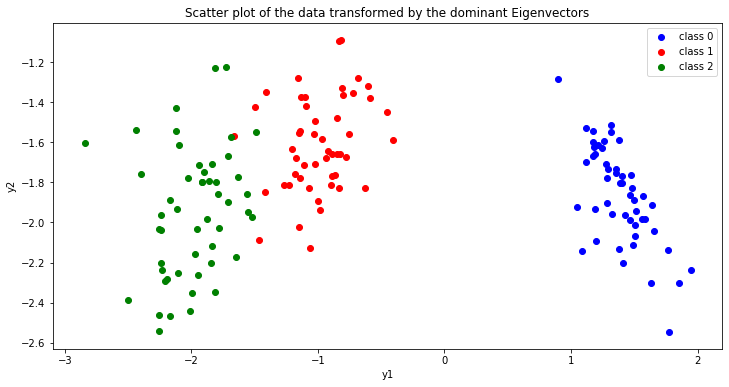

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.set(xlabel="y1", ylabel="y2", title = "Scatter plot of the data transformed by the dominant Eigenvectors")
ax.scatter(w0_0, w0_1 , c='b', label='class 0')
ax.scatter(w1_0, w1_1 , c='r', label='class 1')
ax.scatter(w2_0, w2_1 , c='g', label='class 2')
ax.legend()

In [98]:
print(W)
w_final = W.T

[[ 0.20874182 -0.00653196]
 [ 0.38620369 -0.58661055]
 [-0.55401172  0.25256154]
 [-0.7073504  -0.76945309]]


In [99]:
print(w_final)

[[ 0.20874182  0.38620369 -0.55401172 -0.7073504 ]
 [-0.00653196 -0.58661055  0.25256154 -0.76945309]]


In [100]:
w_eig = w_final[0]
w_eig = np.asarray(w_eig)
w_eig = np.reshape(w_eig, (4,1))

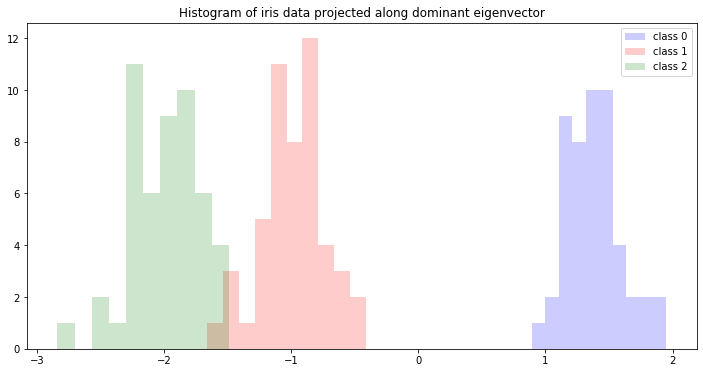

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

ax.hist(proj_y(w_eig, class_0), color='b',alpha=0.2, label="class 0")
ax.hist(proj_y(w_eig, class_1), color='r',alpha=0.2, label="class 1")
ax.hist(proj_y(w_eig, class_2), color='g',alpha=0.2, label="class 2")
ax.set_title("Histogram of iris data projected along dominant eigenvector", fontsize = 12)
ax.legend()